# Compare 72 vs 74

## Initial conditions

**72**:

WOA18 1 deg, 103 depth levels, with horizontal filling

/glade/work/bryan/Observations/WOA18/woa18_decav_merged_monthly_deep_filled_01.nc

**74**:

WOA18 0.25 deg, 103 depth levels, with horizontal filling

/glade/work/bryan/Observations/WOA18/woa18_decav_m00_deep_filled_04.nc

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot, yzplot 
from mom6_tools.m6toolbox import genBasinMasks
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
path = '/glade/scratch/gmarques/'
case = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.072']
grd_xr = MOM6grid('/glade/scratch/gmarques/'+str(case[0])+'/run/'+str(case[0])+'.mom6.static.nc',xrformat=True)

grd = MOM6grid('/glade/scratch/gmarques/'+str(case[0])+'/run/'+str(case[0])+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


In [3]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.072','g.c2b6.GJRA.TL319_t061.long_JRA_mct.074B']
labels = ['G72','G74']

# Initial conditions 

In [4]:
ic_mom1_t = xr.open_mfdataset(path+exps[0]+'/run/MOM_IC.nc')['Temp'].mean('Time').load()
ic_mom2_t = xr.open_mfdataset(path+exps[1]+'/run/MOM_IC.nc')['Temp'].mean('Time').load()
ic_mom1_s = xr.open_mfdataset(path+exps[0]+'/run/MOM_IC.nc')['Salt'].mean('Time').load()
ic_mom2_s = xr.open_mfdataset(path+exps[1]+'/run/MOM_IC.nc')['Salt'].mean('Time').load()

## Difference in the initial T/S conditions at selected vertical levels 

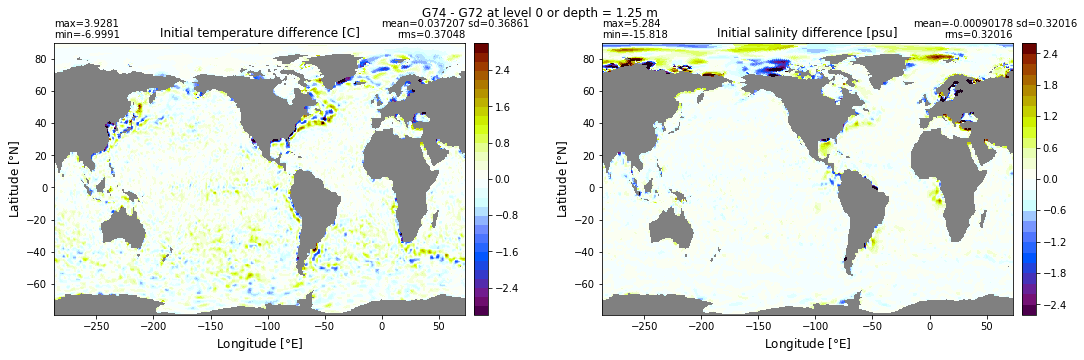

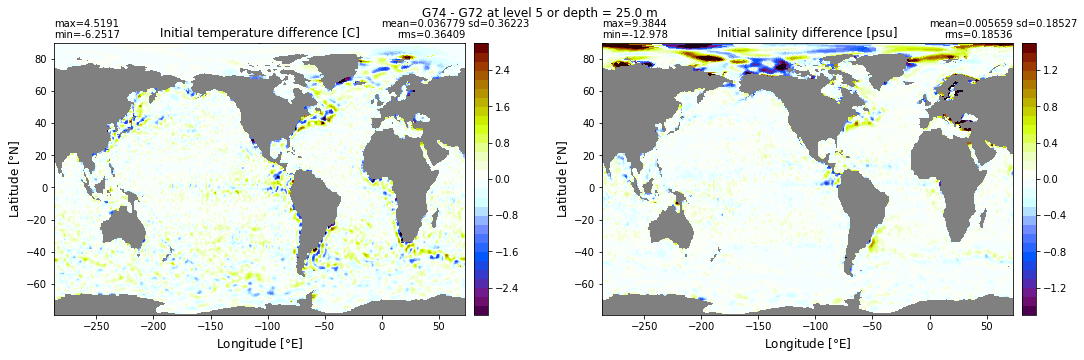

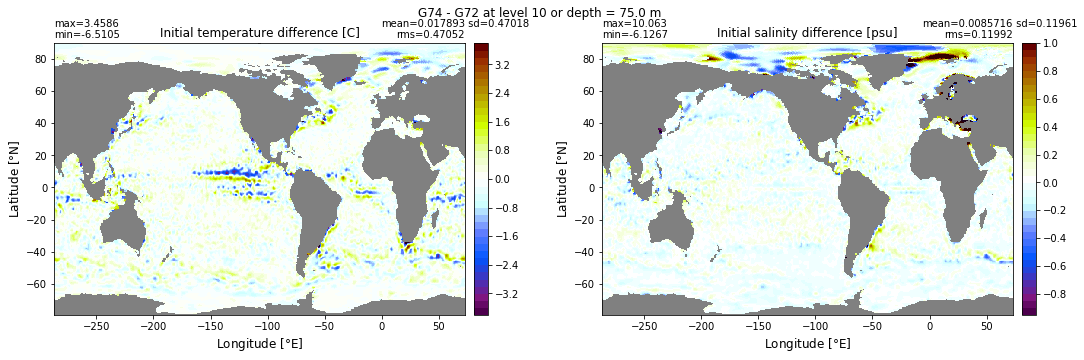

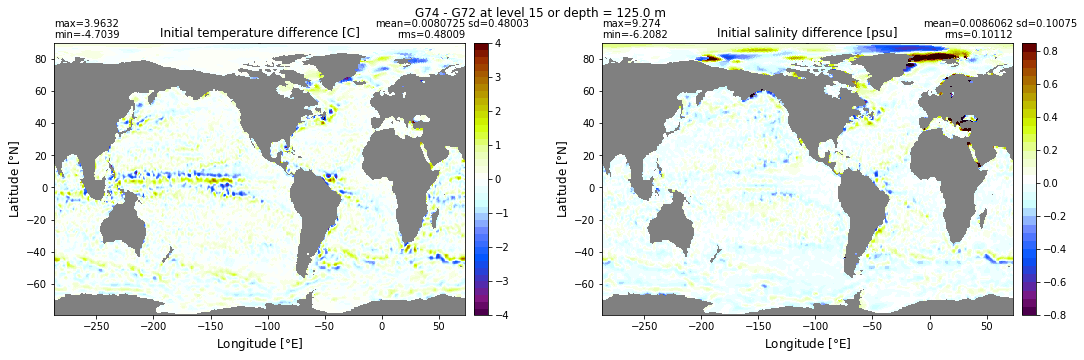

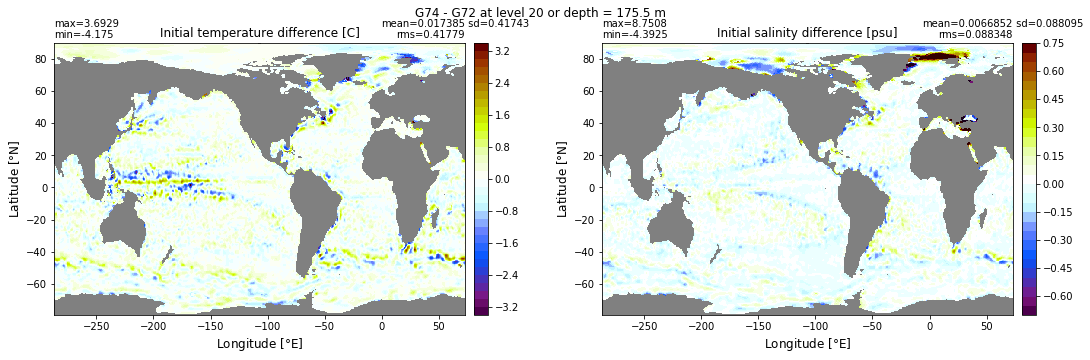

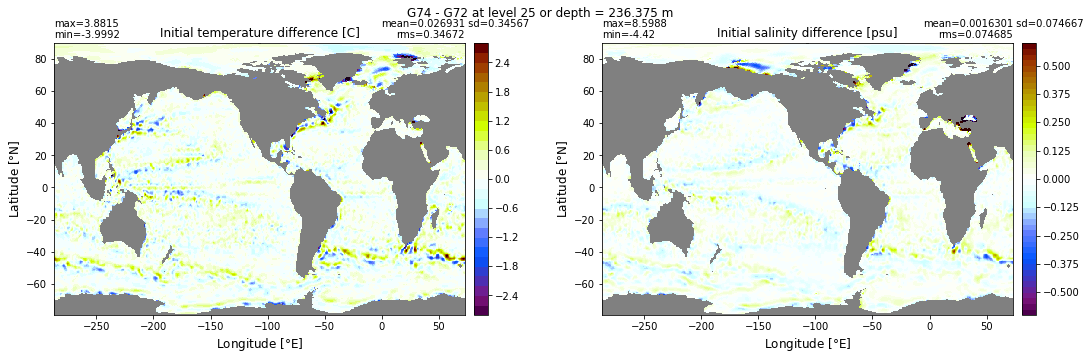

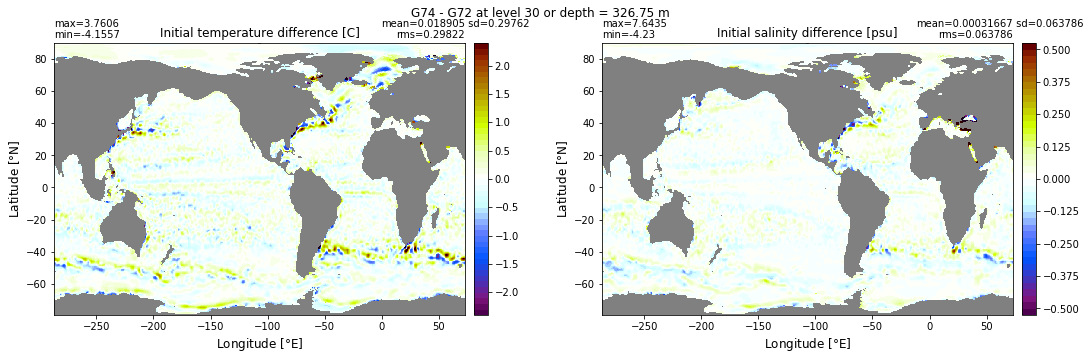

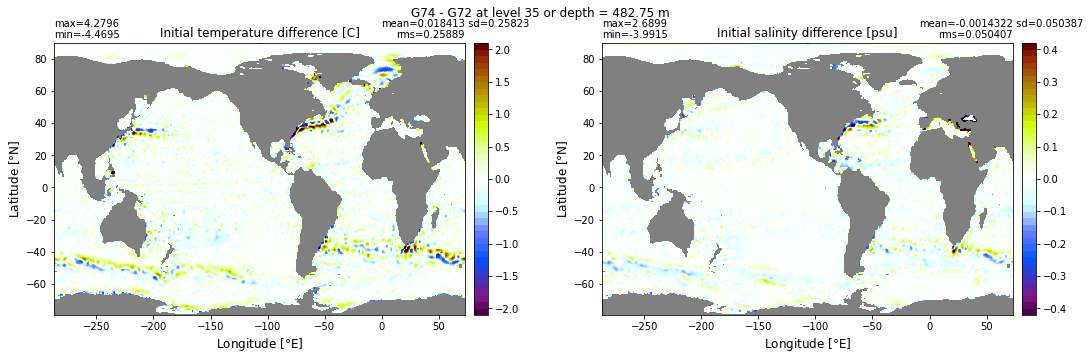

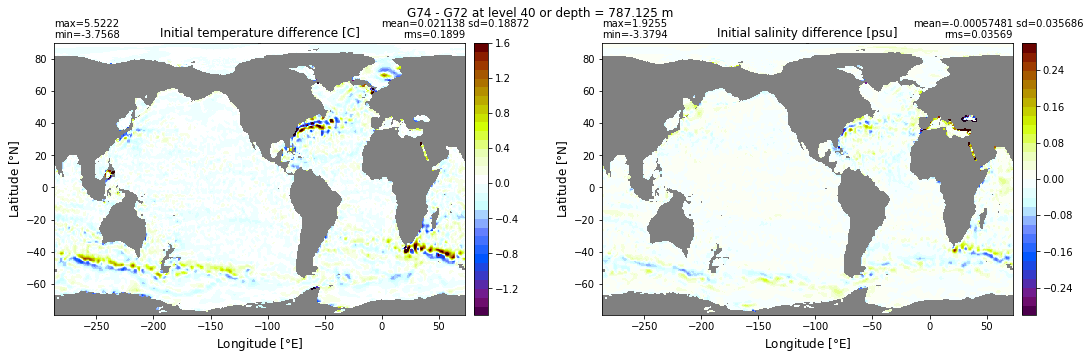

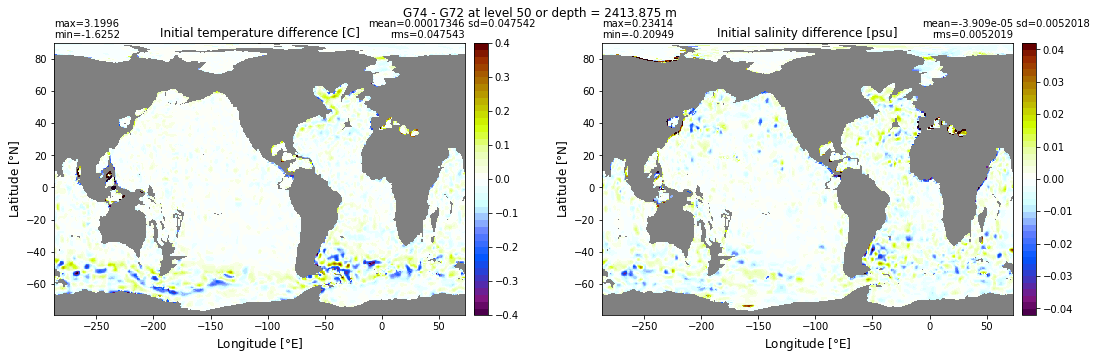

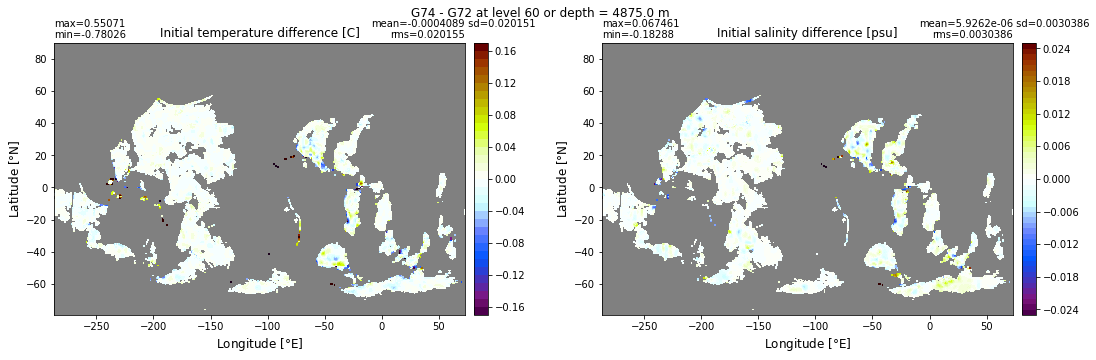

In [5]:
%matplotlib inline
# change k indice to see bias at other depths
levels=[0,5,10,15,20,25,30,35,40,50,60]
for k in levels:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
  ax1 = ax.flatten()
  temp_mom1 = np.ma.masked_where(grd.depth_ocean < ic_mom1_t.Layer[k].values, np.ma.masked_invalid(ic_mom1_t[k,:].values))
  temp_mom2 = np.ma.masked_where(grd.depth_ocean < ic_mom1_t.Layer[k].values, np.ma.masked_invalid(ic_mom2_t[k,:].values))
  salt_mom1 = np.ma.masked_where(grd.depth_ocean < ic_mom1_t.Layer[k].values, np.ma.masked_invalid(ic_mom1_s[k,:].values))
  salt_mom2 = np.ma.masked_where(grd.depth_ocean < ic_mom1_t.Layer[k].values, np.ma.masked_invalid(ic_mom2_s[k,:].values))
    
  plt.suptitle(str(labels[1]+' - '+labels[0])+' at level {} or depth = {} m'.format(k, 
               ic_mom1_t.Layer[k].values))
  xyplot(temp_mom2-temp_mom1, grd.geolon, grd.geolat, grd.area_t, title='Initial temperature difference [C]', axis=ax1[0], 
         nbins=50, sigma=8)
  xyplot(salt_mom2-salt_mom1, grd.geolon, grd.geolat, grd.area_t, title='Initial salinity difference [psu]', axis=ax1[1], 
         nbins=50, sigma=8)

## Zonally averaged initial T/S differences   

In [6]:
# MOM
# reconstruct interfaces
elev_mom = np.concatenate([0,np.diff(ic_mom1_t.Layer).cumsum(),6000.], axis=None)
[_, z_mom] = np.meshgrid(ic_mom1_t.lath.values, -elev_mom)

mom1_temp_ic = xr.DataArray((ic_mom1_t.values) , dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ic_mom1_t.Layer.values, 'yh': ic_mom1_t.lath.values, 'xh':ic_mom1_t.lonh.values})
mom1_salt_ic = xr.DataArray((ic_mom1_s.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ic_mom1_t.Layer.values, 'yh': ic_mom1_t.lath.values, 'xh':ic_mom1_t.lonh.values})

mom2_temp_ic = xr.DataArray((ic_mom2_t.values) , dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ic_mom2_t.Layer.values, 'yh': ic_mom2_t.lath.values, 'xh':ic_mom2_t.lonh.values})
mom2_salt_ic = xr.DataArray((ic_mom2_s.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ic_mom2_t.Layer.values, 'yh': ic_mom2_t.lath.values, 'xh':ic_mom2_t.lonh.values})

# construct a 3D area with land values masked
area = np.ma.masked_where(grd.wet == 0,grd.area_t)
tmp = np.repeat(area[np.newaxis, :, :], len(ic_mom1_t.Layer), axis=0)
area3D = xr.DataArray(tmp, dims=('z_l', 'yh','xh'), 
                          coords={'z_l':ic_mom1_t.Layer.values, 'yh': ic_mom1_t.lath.values, 
                                  'xh':ic_mom1_t.lonh.values})
for k in range(len(area3D.z_l)):
    area3D[k,:] = grd_xr.area_t.where(grd_xr.depth_ocean >= area3D.z_l[k]) 

### Global   

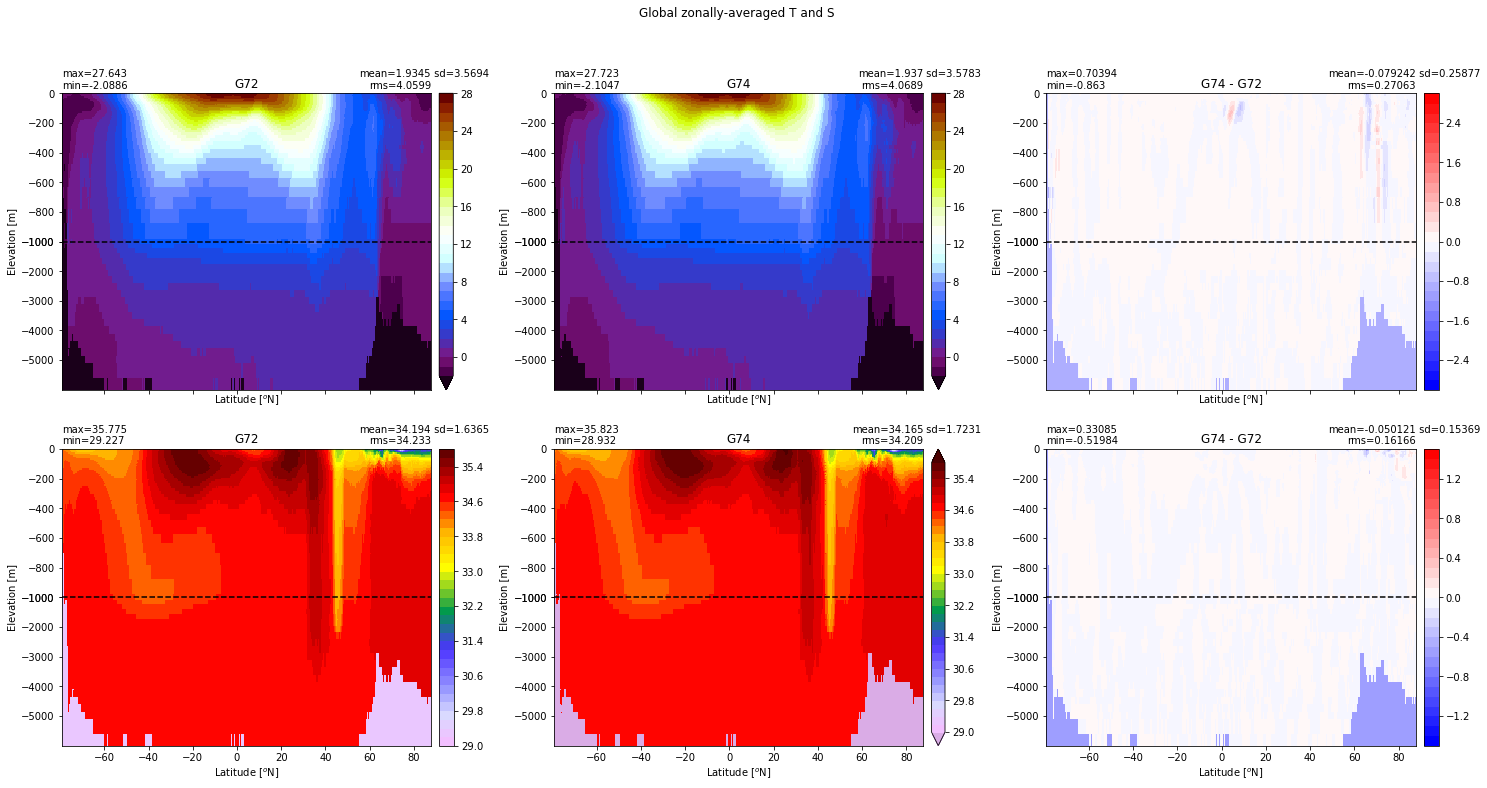

In [7]:
mom1_temp_global_ic = ((mom1_temp_ic * area3D).sum('xh')/area3D.sum('xh'))
mom2_temp_global_ic = ((mom2_temp_ic * area3D).sum('xh')/area3D.sum('xh'))
mom1_salt_global_ic = ((mom1_salt_ic * area3D).sum('xh')/area3D.sum('xh'))
mom2_salt_global_ic = ((mom2_salt_ic * area3D).sum('xh')/area3D.sum('xh'))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,12), sharex=True)
ax1 = ax.flatten()
plt.suptitle('Global zonally-averaged T and S')

# temp
yzplot(np.ma.masked_invalid(mom1_temp_global_ic), mom1_temp_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[0], nbins=50,clim=(-2, 28), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_global_ic), mom2_temp_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[1], nbins=50, clim=(-2, 28), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_global_ic-mom1_temp_global_ic), mom2_temp_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-3, 3)); ax1[2].invert_yaxis()

# salt
yzplot(np.ma.masked_invalid(mom1_salt_global_ic), mom1_salt_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[3], nbins=50,clim=(29, 35.8), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[3].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_salt_global_ic), mom2_salt_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[4], nbins=50, clim=(29, 35.8), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[4].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_salt_global_ic-mom1_salt_global_ic), mom2_salt_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[5], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-1.5, 1.5)); ax1[5].invert_yaxis()


### Atlantic

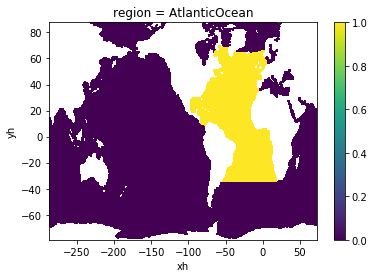

In [8]:
basin_code.sel(region='AtlanticOcean').where(grd_xr.wet==1).plot()

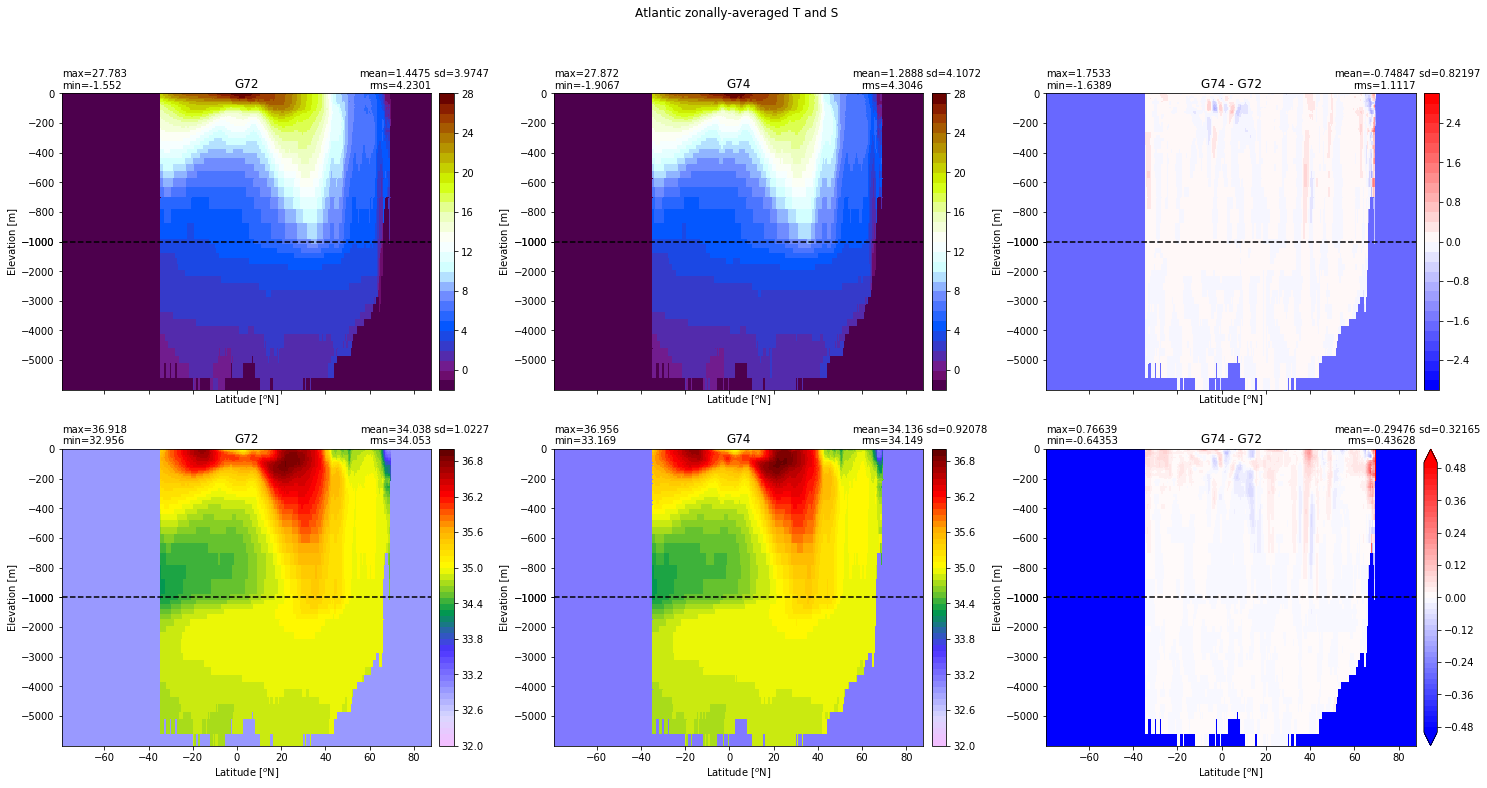

In [9]:
area3_alt = basin_code.sel(region='AtlanticOcean') * area3D
area3_alt = area3_alt.where(area3_alt>0)
mom1_temp_alt_ic = ((area3_alt*mom1_temp_ic).sum('xh')/area3_alt.sum('xh')).transpose()
mom1_salt_alt_ic = ((area3_alt*mom1_salt_ic).sum('xh')/area3_alt.sum('xh')).transpose()
mom2_temp_alt_ic = ((area3_alt*mom2_temp_ic).sum('xh')/area3_alt.sum('xh')).transpose()
mom2_salt_alt_ic = ((area3_alt*mom2_salt_ic).sum('xh')/area3_alt.sum('xh')).transpose()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,12), sharex=True)
ax1 = ax.flatten()
plt.suptitle('Atlantic zonally-averaged T and S')

# temp
yzplot(np.ma.masked_invalid(mom1_temp_alt_ic), mom1_temp_alt_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[0], nbins=50,clim=(-2, 28), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_alt_ic), mom2_temp_alt_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[1], nbins=50, clim=(-2, 28), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_alt_ic-mom1_temp_alt_ic), mom2_temp_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-3, 3)); ax1[2].invert_yaxis()

# salt
yzplot(np.ma.masked_invalid(mom1_salt_alt_ic), mom1_salt_alt_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[3], nbins=50,clim=(32, 37), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[3].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_salt_alt_ic), mom2_salt_alt_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[4], nbins=50, clim=(32, 37), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[4].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_salt_alt_ic-mom1_salt_alt_ic), mom2_salt_alt_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[5], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-.5, .5)); ax1[5].invert_yaxis()


### Pacific

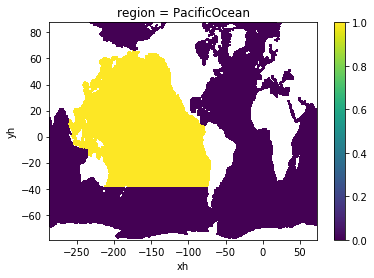

In [10]:
basin_code.sel(region='PacificOcean').where(grd_xr.wet==1).plot()

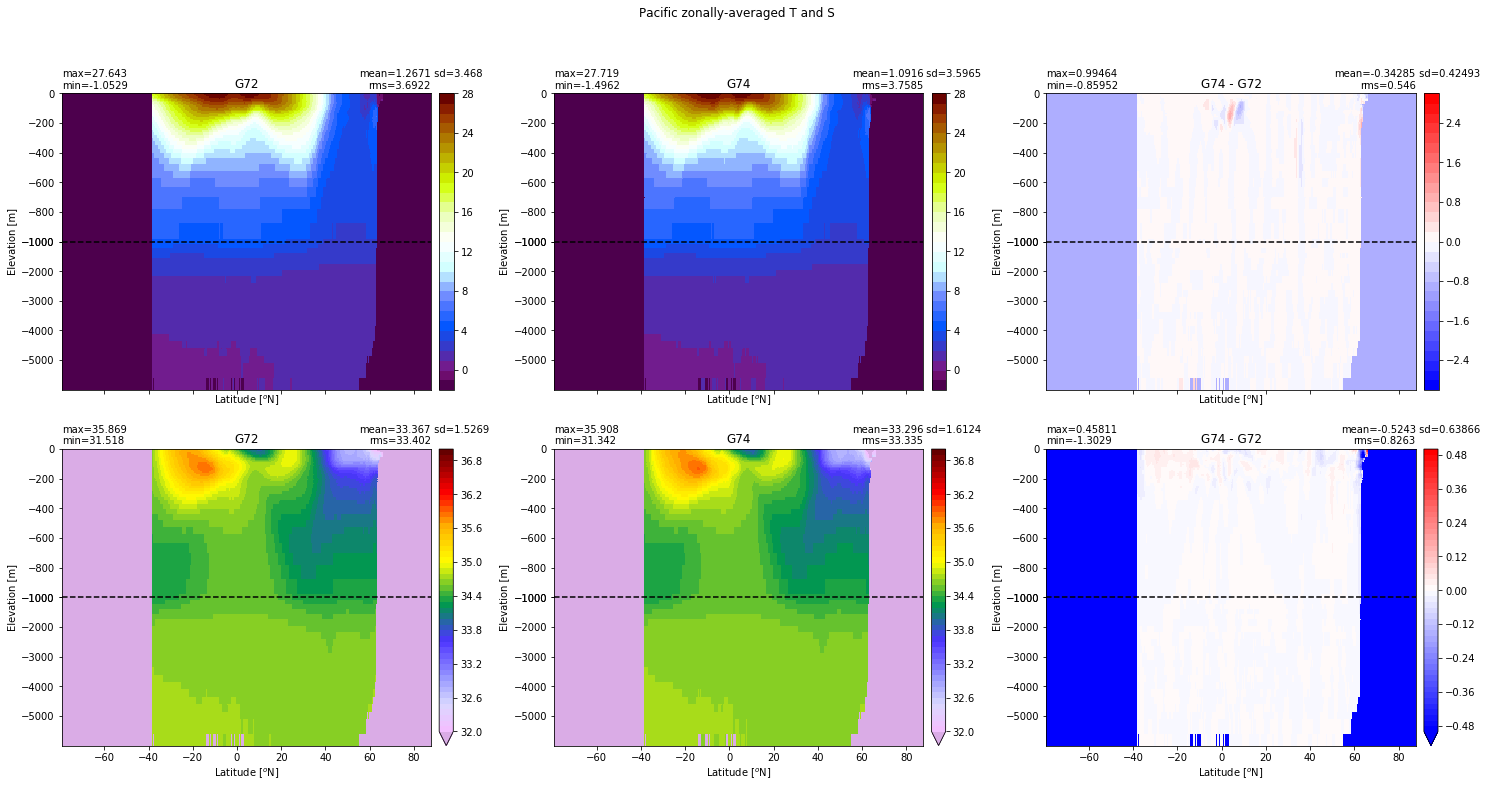

In [11]:
area3_pac = basin_code.sel(region='PacificOcean') * area3D
area3_pac = area3_pac.where(area3_pac>0)

mom1_temp_pac_ic = ((area3_pac*mom1_temp_ic).sum('xh')/area3_pac.sum('xh')).transpose()
mom1_salt_pac_ic = ((area3_pac*mom1_salt_ic).sum('xh')/area3_pac.sum('xh')).transpose()
mom2_temp_pac_ic = ((area3_pac*mom2_temp_ic).sum('xh')/area3_pac.sum('xh')).transpose()
mom2_salt_pac_ic = ((area3_pac*mom2_salt_ic).sum('xh')/area3_pac.sum('xh')).transpose()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,12), sharex=True)
ax1 = ax.flatten()
plt.suptitle('Pacific zonally-averaged T and S')

# temp
yzplot(np.ma.masked_invalid(mom1_temp_pac_ic), mom1_temp_pac_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[0], nbins=50,clim=(-2, 28), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_pac_ic), mom2_temp_pac_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[1], nbins=50, clim=(-2, 28), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_pac_ic-mom1_temp_pac_ic), mom2_temp_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-3, 3)); ax1[2].invert_yaxis()

# salt
yzplot(np.ma.masked_invalid(mom1_salt_pac_ic), mom1_salt_pac_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[3], nbins=50,clim=(32, 37), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[3].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_salt_pac_ic), mom2_salt_pac_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[4], nbins=50, clim=(32, 37), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[4].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_salt_pac_ic-mom1_salt_pac_ic), mom1_salt_pac_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[5], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-.5, .5)); ax1[5].invert_yaxis()


### Med Sea

(30, 50)

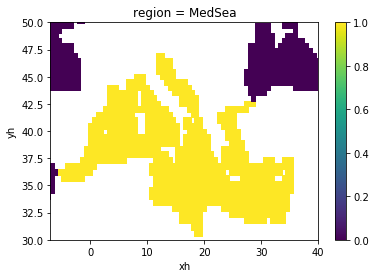

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
basin_code.sel(region='MedSea').where(grd_xr.wet==1).plot(ax=ax)
ax.set_xlim(-7,40)
ax.set_ylim(30,50)

(30, 48)

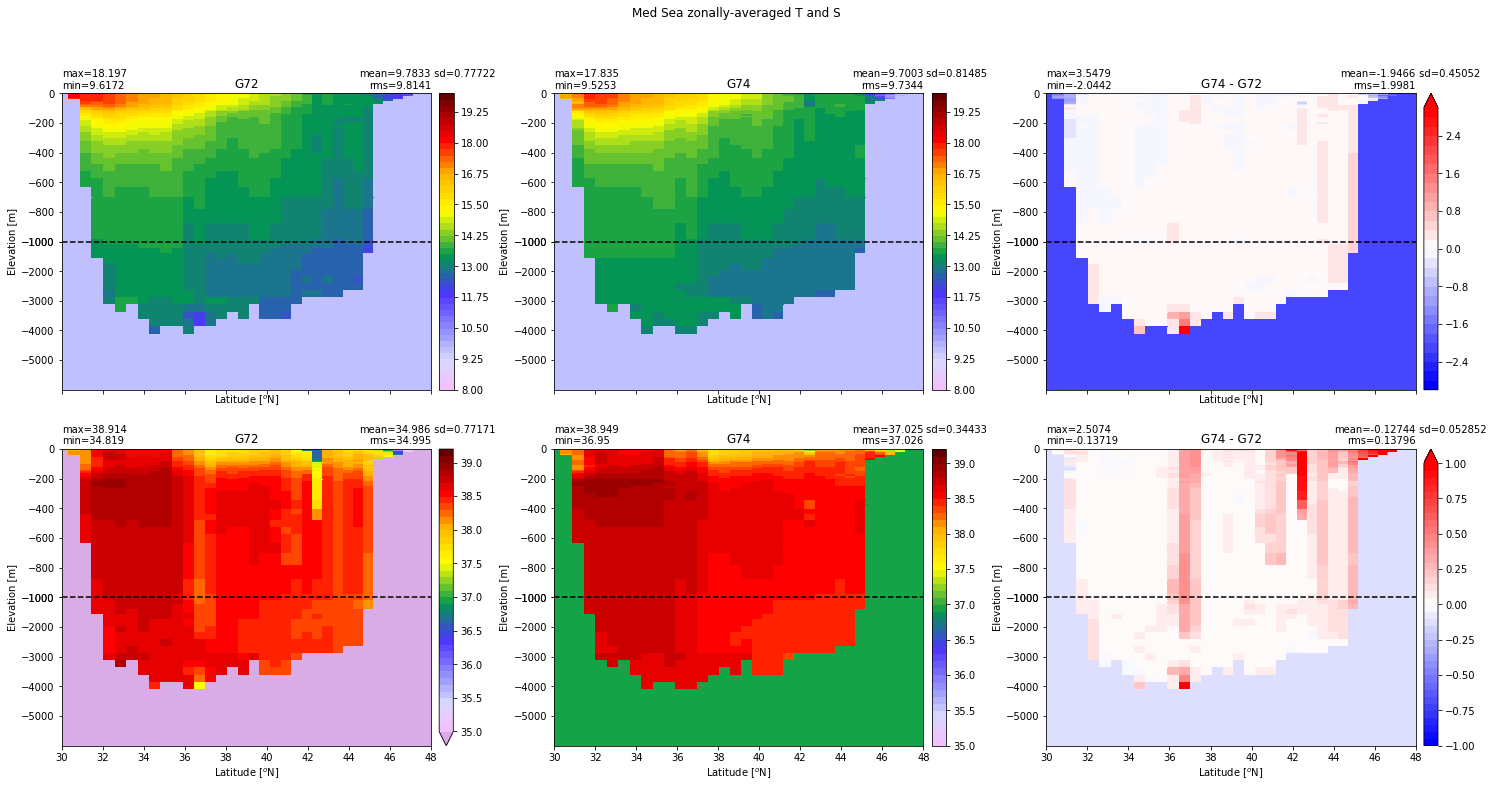

In [13]:
area3_med = basin_code.sel(region='MedSea') * area3D
area3_med = area3_med.where(area3_med>0)

mom1_temp_med_ic = ((area3_med*mom1_temp_ic).sum('xh')/area3_med.sum('xh')).transpose()
mom1_salt_med_ic = ((area3_med*mom1_salt_ic).sum('xh')/area3_med.sum('xh')).transpose()
mom2_temp_med_ic = ((area3_med*mom2_temp_ic).sum('xh')/area3_med.sum('xh')).transpose()
mom2_salt_med_ic = ((area3_med*mom2_salt_ic).sum('xh')/area3_med.sum('xh')).transpose()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,12), sharex=True)
ax1 = ax.flatten()
plt.suptitle('Med Sea zonally-averaged T and S')

# temp
yzplot(np.ma.masked_invalid(mom1_temp_med_ic), mom1_temp_med_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[0], nbins=50,clim=(8, 20), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()
ax1[0].set_xlim(30,48)
yzplot(np.ma.masked_invalid(mom2_temp_med_ic), mom2_temp_med_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[1], nbins=50, clim=(8, 20), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()
ax1[1].set_xlim(30,48)
yzplot(np.ma.masked_invalid(mom2_temp_med_ic-mom1_temp_med_ic), mom2_temp_global_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-3, 3)); ax1[2].invert_yaxis()
ax1[2].set_xlim(30,48)
# salt
yzplot(np.ma.masked_invalid(mom1_salt_med_ic), mom1_salt_med_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]), 
       axis=ax1[3], nbins=50,clim=(35, 39.2), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[3].invert_yaxis()
ax1[3].set_xlim(30,48)
yzplot(np.ma.masked_invalid(mom2_salt_med_ic), mom2_salt_med_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]), 
       axis=ax1[4], nbins=50, clim=(35, 39.2), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[4].invert_yaxis()
ax1[4].set_xlim(30,48)
yzplot(np.ma.masked_invalid(mom2_salt_med_ic-mom1_salt_med_ic), mom2_salt_med_ic.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[5], nbins=50, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-1, 1)); ax1[5].invert_yaxis()
ax1[5].set_xlim(30,48)

(29, 48)

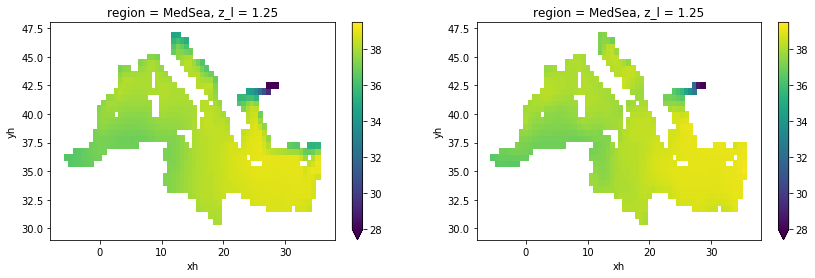

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
(area3_med*mom1_salt_ic/area3_med)[:,:,0].plot(ax=ax[0], vmin=28, vmax=39.5)
(area3_med*mom2_salt_ic/area3_med)[:,:,0].plot(ax=ax[1], vmin=28, vmax=39.5)

ax[0].set_xlim(-8,38);ax[0].set_ylim(29,48)
ax[1].set_xlim(-8,38);ax[1].set_ylim(29,48)

(29, 48)

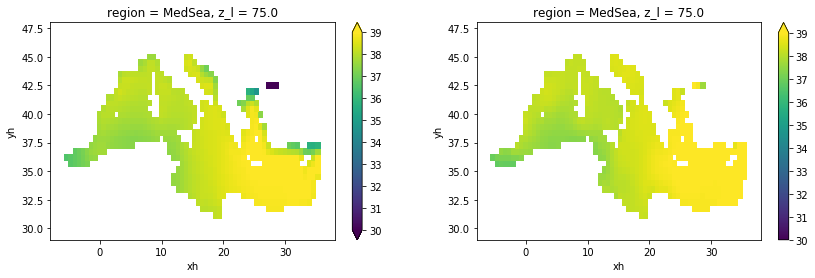

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
(area3_med*mom1_salt_ic/area3_med)[:,:,10].plot(ax=ax[0], vmin=30, vmax=39.)
(area3_med*mom2_salt_ic/area3_med)[:,:,10].plot(ax=ax[1], vmin=30, vmax=39.)

ax[0].set_xlim(-8,38);ax[0].set_ylim(29,48)
ax[1].set_xlim(-8,38);ax[1].set_ylim(29,48)